# Diagnosis Of Breast Cancer

Thời lượng ước tính: **120** phút

## Giới thiệu Lab
Ung thư vú thường bắt nguồn từ sự phát triển không kiểm soát của các tế bào tạo nên các ống dẫn sữa. Mặc dù khá hiếm gặp ở nam giới (ít hơn 0,1% mắc bệnh này), nhưng theo BreastCancer.org, 1/8 phụ nữ (12%) mắc phải một dạng ung thư vú ác tính trong suốt cuộc đời của họ. Những tế bào xâm lấn này tạo thành khối u phá hủy mô lân cận, có thể lây lan sang các bộ phận khác của cơ thể, và nếu không được điều trị thích hợp thì có thể dẫn đến tử vong. Nói một cách dễ hiểu, ở Mỹ mỗi năm  có khoảng 600 phụ nữ chết do các biến chứng liên quan đến thai nghén ... nhưng có tới hơn 40.000 người chết do ung thư vú.

Ung thư vú không phát triển trong chốc lát và giống như bất kỳ bệnh ung thư nào khác, nó có thể được điều trị cực kỳ hiệu quả nếu được phát hiện ở giai đoạn sớm hơn. Một phần kiến thức về bệnh ung thư là biết rằng không phải tất cả các tế bào phát triển không đều đều là ác tính; một số là sự phát triển lành tính, hoặc không nguy hiểm, không phải ung thư. Khối u lành tính không có nghĩa là không tăng kích thước, mà nó chỉ không gây ra mối đe dọa cho các mô lân cận, cũng như không có khả năng lây lan sang các bộ phận khác của cơ thể. Nó chỉ đơn giản ở đó để phát triển. Các khối u lành tính thực sự khá phổ biến, chẳng hạn như nốt ruồi và một số mụn cóc. Do đó, có thể đánh giá chính xác xem một khối u là lành tính hay ác tính, có thể bỏ qua được hay rất đáng báo động; và đây là một bài toán có thể giải quyết được thông qua dữ liệu và machine learning (học máy).

Trong lab này, bạn sẽ sử dụng tập dữ liệu **[Breast Cancer Wisconsin Original](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original))**, được cung cấp với sự hỗ trợ của Machine Learning Repository từ UCI. Dưới đây là tên cột, bạn có thể đọc thêm chi tiết trên trang thông tin của tập dữ liệu:

**['sample', 'thickness', 'size', 'shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'status']**

In [1]:
import random, math
import pandas as pd
import numpy as np
import scipy.io

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.style.use('ggplot') # Look Pretty


# Leave this alone until indicated:
Test_PCA = False

### Hàm hữu ích

Phương pháp này chỉ nhằm mục đích thuận tiện cho việc trực quan hóa. Bạn không nên tự kết hợp điều này với nhau, dù bây giờ bạn có thể làm theo code:

In [2]:
def plotDecisionBoundary(model, X, y):
    print("Plotting...")

    fig = plt.figure()
    ax = fig.add_subplot(111)

    padding = 0.1
    resolution = 0.1

    #(2 for benign, 4 for malignant)
    colors = {2:'royalblue', 4:'lightsalmon'} 


    # Calculate the boundaris
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Create a 2D Grid Matrix. The values stored in the matrix
    # are the predictions of the class at at said location
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # What class does the classifier say?
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour map
    plt.contourf(xx, yy, Z, cmap=plt.cm.seismic)
    plt.axis('tight')

    # Plot your testing points as well...
    for label in np.unique(y):
        indices = np.where(y == label)
        plt.scatter(X[indices, 0], X[indices, 1], c=colors[label], alpha=0.8)

    p = model.get_params()
    plt.title('K = ' + str(p['n_neighbors']))
    plt.show()

## 1. Chuẩn bị dữ liệu

Load trong tập dữ liệu (**breast-cancer-wisconsin.data**), xác định nans, và đặt đúng header (tiêu đề). Đảm bảo xác minh các hàng đã sắp xếp bằng cách xem tệp trong trình soạn thảo văn bản.

In [18]:
# .. Nhập code của bạn ở đây ..
cols_name =['sample','thickness','size','shape','adhesion','epithelial','nuclei','chromatin','nucleoli','mitoses','status']
df = pd.read_csv('breast-cancer-wisconsin.data',names=cols_name,na_values=True)
df.head()

,sample,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,status
0,1000025,5.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,2
1,1002945,5.0,4.0,4.0,5.0,7.0,10,3.0,2.0,NaN,2
2,1015425,3.0,NaN,NaN,NaN,2.0,2,3.0,NaN,NaN,2
3,1016277,6.0,8.0,8.0,NaN,3.0,4,3.0,7.0,NaN,2
4,1017023,4.0,NaN,NaN,3.0,2.0,NaN,3.0,NaN,NaN,2


Sao chép cột trạng thái vào một slice, sau đó thả cột đó khỏi khung dữ liệu chính. Luôn xác minh rằng bạn đã thực hiện thả đúng cách bằng cách kiểm tra kỹ (in ra kết quả hoạt động)! Nhiều người quên đặt trục bên phải ở đây.

Nếu bạn cảm thấy khó chịu khi load tập dữ liệu và nhận thấy rằng bạn có cột `sample`, bạn cũng nên bỏ qua nó nếu bạn chưa có.

In [19]:
# .. Nhập code của bạn ở đây ..
y = df.iloc[:,-1]
df.drop(labels= ['status'],axis = 1,inplace=True)

In [20]:
df.head()

,sample,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses
0,1000025,5.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN
1,1002945,5.0,4.0,4.0,5.0,7.0,10,3.0,2.0,NaN
2,1015425,3.0,NaN,NaN,NaN,2.0,2,3.0,NaN,NaN
3,1016277,6.0,8.0,8.0,NaN,3.0,4,3.0,7.0,NaN
4,1017023,4.0,NaN,NaN,3.0,2.0,NaN,3.0,NaN,NaN


In [21]:
df.drop(labels=['sample'],axis = 1, inplace=True)

In [22]:
df.head()

,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses
0,5.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN
1,5.0,4.0,4.0,5.0,7.0,10,3.0,2.0,NaN
2,3.0,NaN,NaN,NaN,2.0,2,3.0,NaN,NaN
3,6.0,8.0,8.0,NaN,3.0,4,3.0,7.0,NaN
4,4.0,NaN,NaN,3.0,2.0,NaN,3.0,NaN,NaN


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   thickness   554 non-null    float64
 1   size        315 non-null    float64
 2   shape       346 non-null    float64
 3   adhesion    292 non-null    float64
 4   epithelial  652 non-null    float64
 5   nuclei      297 non-null    object 
 6   chromatin   547 non-null    float64
 7   nucleoli    256 non-null    float64
 8   mitoses     120 non-null    float64
dtypes: float64(8), object(1)
memory usage: 49.3+ KB


In [28]:
df.drop(labels=['nuclei'],axis = 1,inplace=True)

In [29]:
X = df

Sau khi các nhãn được xuất an toàn từ tập dữ liệu, hãy thay thế bất kỳ giá trị nan nào bằng giá trị cột/thuộc tính trung bình:

In [30]:
# .. Nhập code của bạn ở đây ..
X = X.fillna(X.mean())

In [31]:
X

,thickness,size,shape,adhesion,epithelial,chromatin,nucleoli,mitoses
0,5.0,5.736508,5.459538,5.325342,2.0,3.000000,6.097656,4.433333
1,5.0,4.000000,4.000000,5.000000,7.0,3.000000,2.000000,4.433333
2,3.0,5.736508,5.459538,5.325342,2.0,3.000000,6.097656,4.433333
3,6.0,8.000000,8.000000,5.325342,3.0,3.000000,7.000000,4.433333
4,4.0,5.736508,5.459538,3.000000,2.0,3.000000,6.097656,4.433333
...,...,...,...,...,...,...,...,...
694,3.0,5.736508,5.459538,5.325342,3.0,4.115174,6.097656,4.433333
695,2.0,5.736508,5.459538,5.325342,2.0,4.115174,6.097656,4.433333
696,5.0,10.000000,10.000000,3.000000,7.0,8.000000,10.000000,2.000000
697,4.0,8.000000,6.000000,4.000000,3.0,10.000000,6.000000,4.433333


In [32]:
y

0      2
1      2
2      2
3      2
4      2
      ..
694    2
695    2
696    4
697    4
698    4
Name: status, Length: 699, dtype: int64

Triển khai train_test_split. Sử dụng các tên biến tương tự như trên nền tảng EdX trong tài liệu đọc, nhưng đặt random_state = 7 cho khả năng tái lập và giữ test_size ở 0,5 (50%).

In [33]:
# .. Nhập code của bạn ở đây ..
from sklearn.model_selection import train_test_split 
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=7)

Thử nghiệm với các bộ chia tỷ lệ tiền xử lý SKLearn cơ bản. Chúng ta biết rằng các thuộc tính gồm các đơn vị khác nhau được trộn lẫn với nhau, do đó khá hợp lý khi cho rằng việc mở rộng thuộc tính là cần thiết. In ra mô tả của tập dữ liệu, chuyển đổi sau đó. Nhớ lại: khi tiền xử lý, mô hình được huấn luyện dựa trên phần nào của tập dữ liệu? Ngoài ra (các) phần nào của tập dữ liệu thực sự được chuyển đổi?

In [34]:
# .. Nhập code của bạn ở đây ..
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(349, 8)
(350, 8)
(349,)
(350,)


In [47]:
#from sklearn.preprocessing import StandardScaler

In [48]:
#X_train = StandardScaler().fit(X_train).transform(X_train)

In [49]:
#X_test = StandardScaler().fit(X_test).transform(X_test)

### Giảm kích thước chiều

[PCA](https://blog.paperspace.com/dimension-reduction-with-principal-component-analysis/) và [Isomap](https://https://blog.paperspace.com/dimension-reduction-with-isomap/) là trợ thủ đắc lực cho bạn

In [35]:
from sklearn.manifold import Isomap
model = None
if Test_PCA:
    print("Computing 2D Principle Components")
    model = PCA(n_components=2)
else:
    print("Computing 2D Isomap Manifold")
model = Isomap(n_neighbors=5, n_components=2)

Computing 2D Isomap Manifold


In [37]:
data_train = model.fit(X_train).transform(X_train)
data_test = model.transform(X_test)

/Users/chinguyen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:304: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/chinguyen/miniforge3/envs/tensorflow/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


## 2. Huấn luyện mô hình

Huấn luyện mô hình của bạn dựa trên data_train, sau đó chuyển đổi cả `data_train` và` data_test` bằng mô hình của bạn. Bạn có thể lưu lại kết quả vào chính các biến.

In [43]:
# .. Nhập code của bạn ở đây ..
from sklearn.neighbors import KNeighborsClassifier
k = 13
neigh = KNeighborsClassifier(n_neighbors = k).fit(data_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=13)

In [44]:
#Dự đoán
y_pred = neigh.predict(data_test)
y_pred[0:12]

array([4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2])

Triển khai và huấn luyện `KNeighborsClassifier` trên dữ liệu huấn luyện 2D dự kiến tại đây. Bạn có thể đặt tên biến của mình là `knmodel`. Bạn có thể sử dụng bất kỳ giá trị `K` nào từ 1 - 15, vậy hãy thử với nó và xem được kết quả nào. Mục tiêu của bạn là tìm sự cân bằng tốt, trong đó bạn không quá cụ thể (K thấp), cũng không quá chung chung (K cao). Bạn cũng nên thử nghiệm xem việc thay đổi tham số trọng số ảnh hưởng đến kết quả ra sao.

In [45]:
# .. Nhập code của bạn ở đây ..
knmodel = KNeighborsClassifier(n_neighbors=k).fit(data_train,y_train)

Hãy luôn ghi nhớ miền của bài toán! Điều quan trọng hơn là phải phân loại sai một khối u lành tính là ác tính và loại bỏ nó hơn là để lại một khối u ác tính một cách không chính xác, tin rằng nó là lành tính, và sau đó ung thư phát triển. Vì trọng số UDF không cung cấp cho bạn bất kỳ thông tin lớp nào, nên cách duy nhất để đưa dữ liệu này vào Bộ phân loại KNN (KNN Classifier) của SKLearn là "kết tụ" nó vào dữ liệu của bạn. Ví dụ, giảm ngẫu nhiên tỷ lệ mẫu lành tính so với mẫu ác tính từ training set.

## 3. Đánh giá mô hình

Tính toán và hiển thị độ chính xác và F1 score của testing set:

In [46]:
# .. Nhập code của bạn ở đây ..
from sklearn.metrics import accuracy_score,f1_score 
yhat = knmodel.predict(data_test)
print("Test set Accuracy: ", accuracy_score(y_test, yhat))
print("F1 score: ",f1_score(y_test,yhat,average='macro'))

Test set Accuracy:  0.8914285714285715
F1 score:  0.8700359599749844


Plotting...


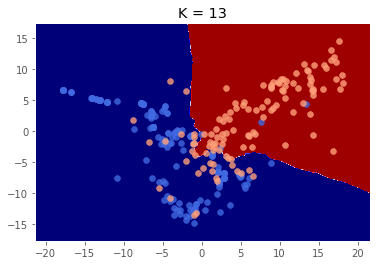

In [47]:
plotDecisionBoundary(knmodel, data_test, y_test)